# Developing a toy model for exploring uncertainties in the Pearson correlation coefficient

We want a model framework that produces "climate-like" signals with the following properties:
- ability to dial up/down the serial correlation
- ability to dial up/down the number of ensemble members to produce realistic smoothing
- explore the effect of trends

Things to maybe explore:
- How wrong can the "standard" block-bootstrap approach be?
- How do different significance tests perform?
- What is the effect of ensemble averaging?
- Can we usefully quantify the impact of trends which are often not removed?
- What do the results mean for the signal-to-noise paradox?
- How sensitive are other metrics? e.g MSE?

In [65]:
import numpy as np

import xarray as xr

import xskillscore as xs

import cartopy
import cartopy.crs as ccrs

from xhistogram.xarray import histogram as xhist

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import Divider, Size

from src import ar_model, stats, utils

In [66]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [67]:
DATA_DIR = "../../../Squire_2022_CAFE-f6/data/"

cartopy.config["pre_existing_data_dir"] = f"{DATA_DIR}/cartopy-data"
cartopy.config["data_dir"] = f"{DATA_DIR}/cartopy-data"

In [68]:
plt.rcParams["figure.figsize"] = (12, 6)

## Load some example real signals to explore and replicate

In [69]:
can = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.precip_global.zarr"
)
can["t_ref"] = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.t_ref_global.zarr"
)["t_ref"]
can["sst"] = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.sst_global.zarr"
)["sst"]

ec = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.precip_global.zarr"
)
ec["t_ref"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.t_ref_global.zarr"
)["t_ref"]
ec["sst"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.sst_global.zarr"
)["sst"]
ec["slp"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.slp_global.zarr"
)["slp"]

## What do the partial autocorrelation functions look like for these fields?

In [70]:
pacf_can = stats.acf(can, partial=True, nlags=3).compute()
pacf_ec = stats.acf(ec, partial=True, nlags=3).compute()

In [7]:
def plot_pacf_lags(pacf, lags, title=None, figsize=None, vrange=(-1, 1)):

    nrows = len(pacf)
    ncols = len(lags)
    if figsize is None:
        figsize = (5.0 * ncols, 2.5 * nrows)

    fig = plt.figure(figsize=figsize)
    axs = fig.subplots(
        nrows,
        ncols,
        sharex=True,
        sharey=True,
        subplot_kw=dict(projection=ccrs.PlateCarree(180)),
    )

    bounds = np.linspace(vrange[0], vrange[1], 21)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)

    for y, l in enumerate(lags):
        for x, v in enumerate(pacf.keys()):
            ax = axs[x, y]
            p = (
                pacf[v]
                .sel(lag=l)
                .plot(
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    vmin=vrange[0],
                    vmax=vrange[1],
                    norm=norm,
                    cmap="RdBu_r",
                    add_colorbar=False,
                )
            )
            p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)

            ax.set_title(f"{v} | lag {l}")

    h = [Size.Fixed(figsize[0] / 12), Size.Fixed(figsize[0] - figsize[0] / 6)]
    v = [Size.Fixed(0), Size.Fixed(0.15)]
    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
    cbar_ax = fig.add_axes(
        divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)
    )
    fig.colorbar(p, cax=cbar_ax, orientation="horizontal")

    if title:
        fig.suptitle(title)

    return fig

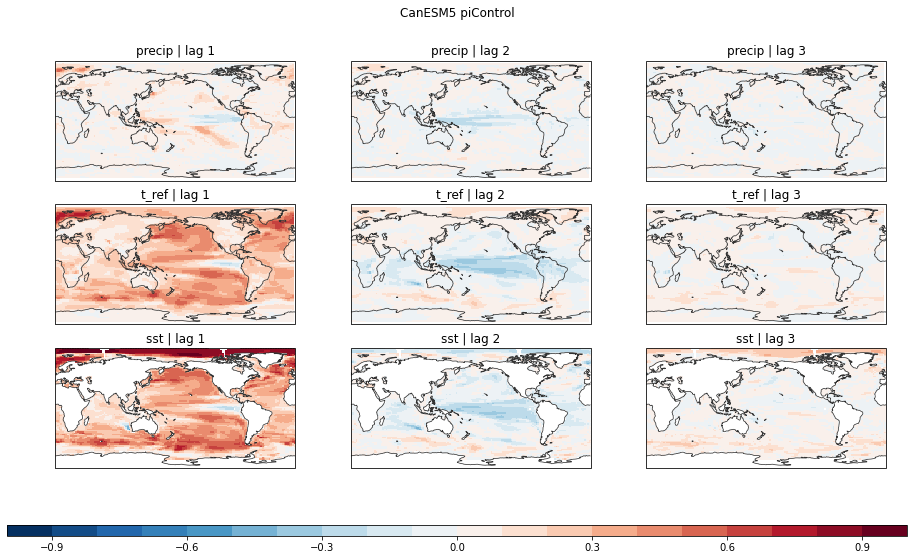

In [8]:
_ = plot_pacf_lags(pacf_can, lags=[1, 2, 3], title="CanESM5 piControl")

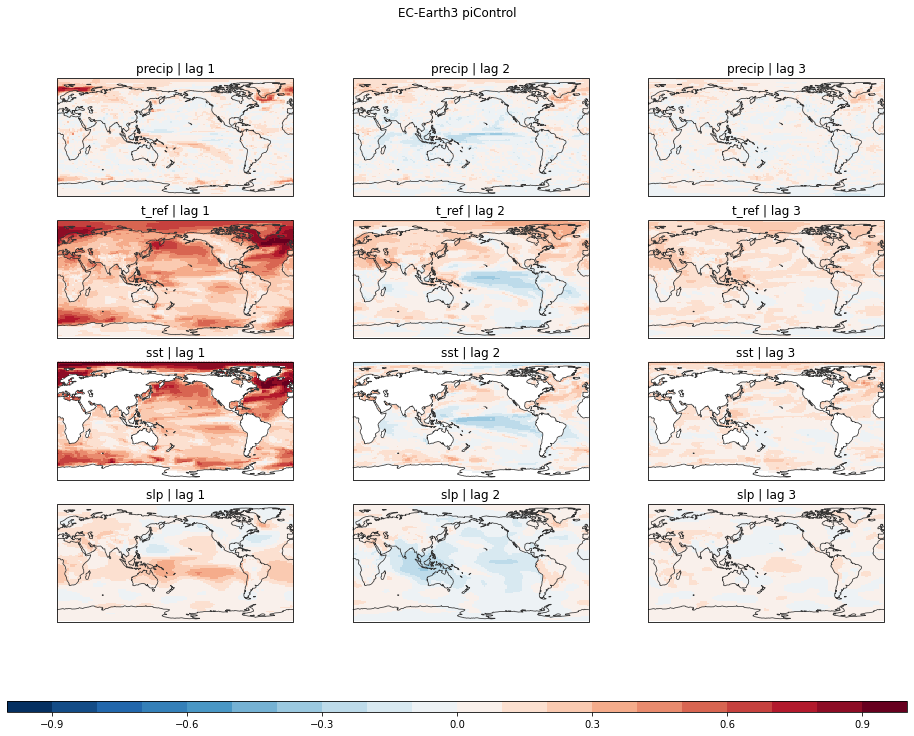

In [9]:
_ = plot_pacf_lags(pacf_ec, lags=[1, 2, 3], title="EC-Earth3 piControl")

## Let's look at how the order 2 coefficient vary across the globe

In [10]:
order = 2

coeffs_can = ar_model.yule_walker(can, order=order).compute()
coeffs_ec = ar_model.yule_walker(ec, order=order).compute()

In [11]:
def plot_coeffs(coeffs, figsize=None):

    ncols = len(coeffs)
    if figsize is None:
        figsize = (5.0 * ncols, 4)

    fig = plt.figure(figsize=figsize)
    axs = fig.subplots(
        1,
        ncols,
        sharex=True,
        sharey=True,
    )

    for i, v in enumerate(coeffs.keys()):
        ax = axs[i]
        p = ax.scatter(
            coeffs[v].sel(coeff=1),
            coeffs[v].sel(coeff=2),
            s=10,
            c=coeffs[v].sel(coeff=0),
        )
        ax.set_xlabel(r"$\phi_{1}$")
        ax.set_ylabel(r"$\phi_{2}$")
        ax.set_title(v)
        ax.grid()

    h = [Size.Fixed(figsize[0] / 12), Size.Fixed(figsize[0] - figsize[0] / 6)]
    v = [Size.Fixed(-0.3), Size.Fixed(0.15)]
    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
    cbar_ax = fig.add_axes(
        divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)
    )
    fig.colorbar(p, cax=cbar_ax, orientation="horizontal", label=r"$\sigma_{\epsilon}$")

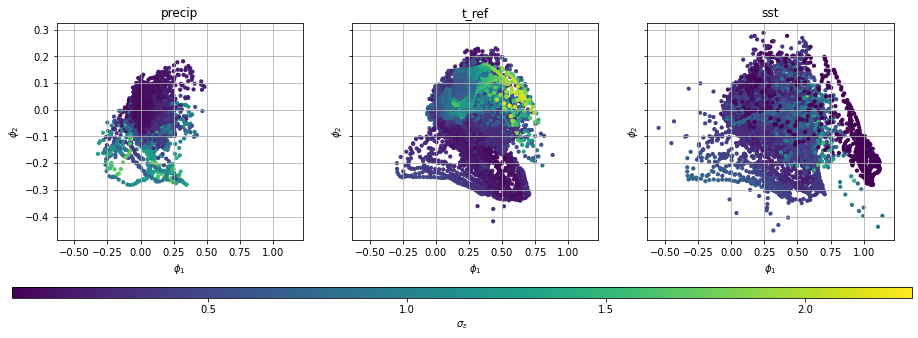

In [12]:
plot_coeffs(coeffs_can)

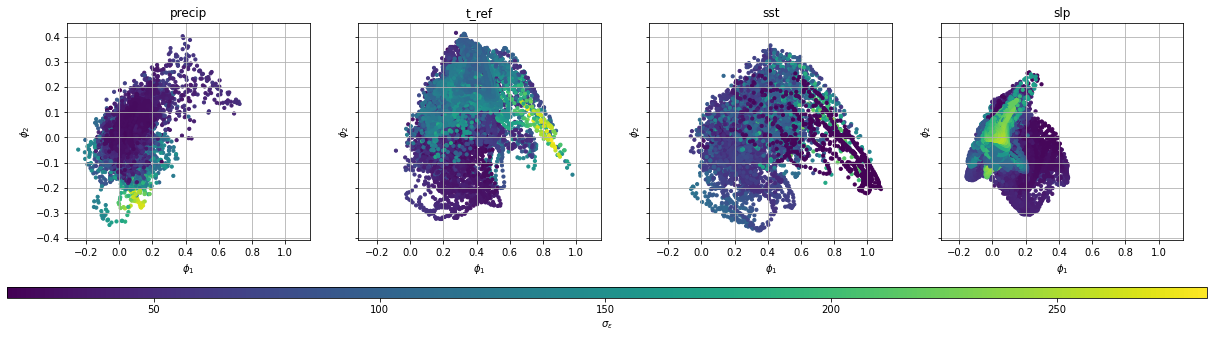

In [13]:
plot_coeffs(coeffs_ec)

# What about coming up with some example cases with similar ACFs to, for example:
- **s1**: highly correlated sst index (e.g. box over Atlantic subpolar gyre - https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL091307, https://link.springer.com/article/10.1007/s00382-014-2212-7)
- **s2**: nao index (e.g. https://www.nature.com/articles/s41612-019-0071-y)
- **s3**: "independent" precip index (e.g. box over Australia)

In [112]:
n_times = 50
n_samples = 1_000
n_members = 50
rolling_means = [2, 4, 8]

## **s1**: Atlantic subpolar gyre

-------------------

In [113]:
spg = utils.detrend(
    utils.extract_subpolar_gyre_region(ec["sst"]),
)

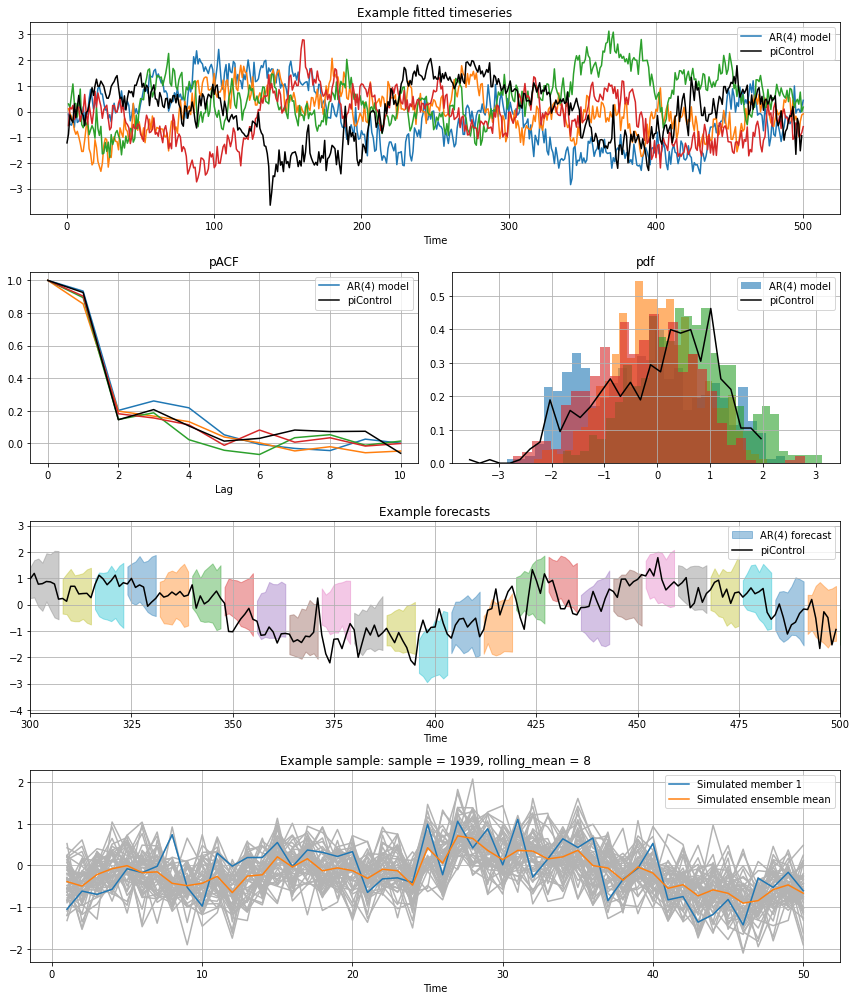

In [115]:
s1_fcst = ar_model.generate_samples_like(
    spg,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    n_members=n_members,
    rolling_means=rolling_means,
    plot_diagnostics=True,
)

s1_obsv = ar_model.generate_samples_like(
    spg,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    rolling_means=rolling_means,
    plot_diagnostics=False,
)

## **s2**: NAO index

-------------------

In [116]:
nao = utils.calculate_NAO_index(ec["slp"]) / 100

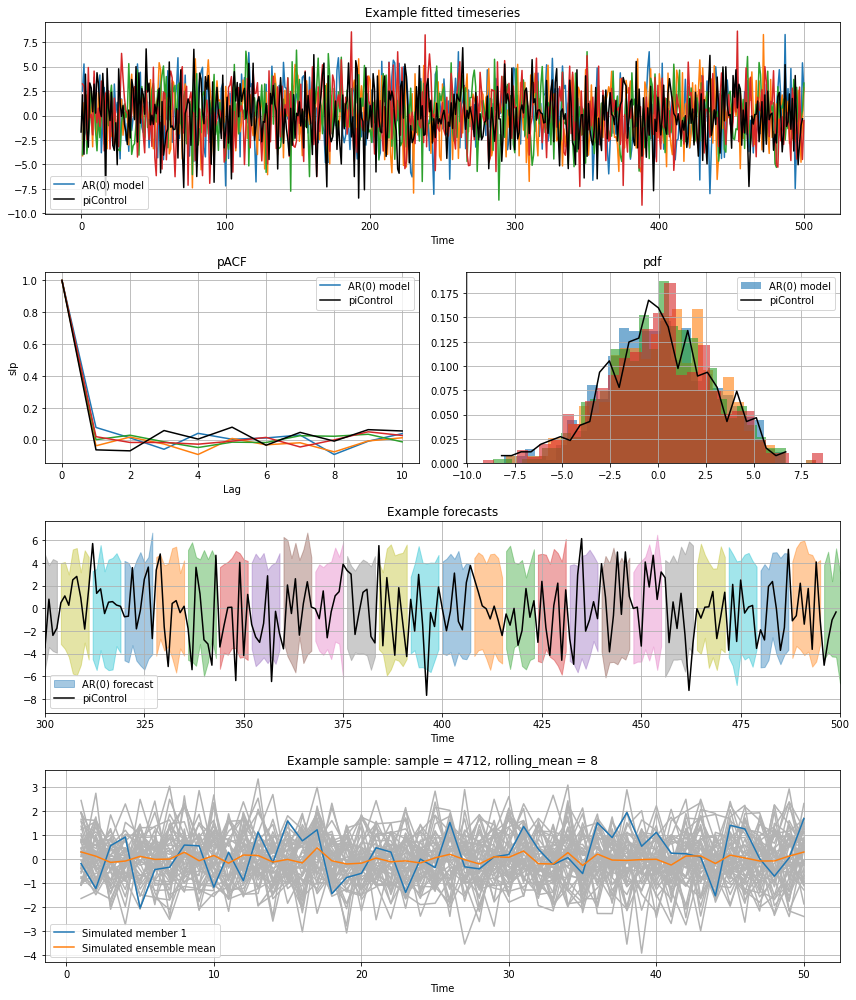

In [117]:
s2_fcst = ar_model.generate_samples_like(
    nao,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    n_members=n_members,
    rolling_means=rolling_means,
    plot_diagnostics=True,
)

s2_obsv = ar_model.generate_samples_like(
    nao,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    rolling_means=rolling_means,
    plot_diagnostics=False,
)

## **s3**: Precipitation over Australia

-------------------

In [118]:
AUS_box = [112, 155, -44, -11]
aus = utils.extract_lon_lat_box(ec["precip"], AUS_box, weighted_average=True)

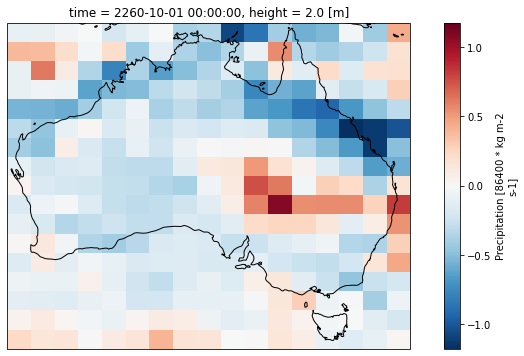

In [119]:
p = (
    utils.extract_lon_lat_box(ec["precip"], AUS_box, weighted_average=False)
    .isel(time=0)
    .plot(
        subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
        transform=ccrs.PlateCarree(),
    )
)
_ = p.axes.coastlines()

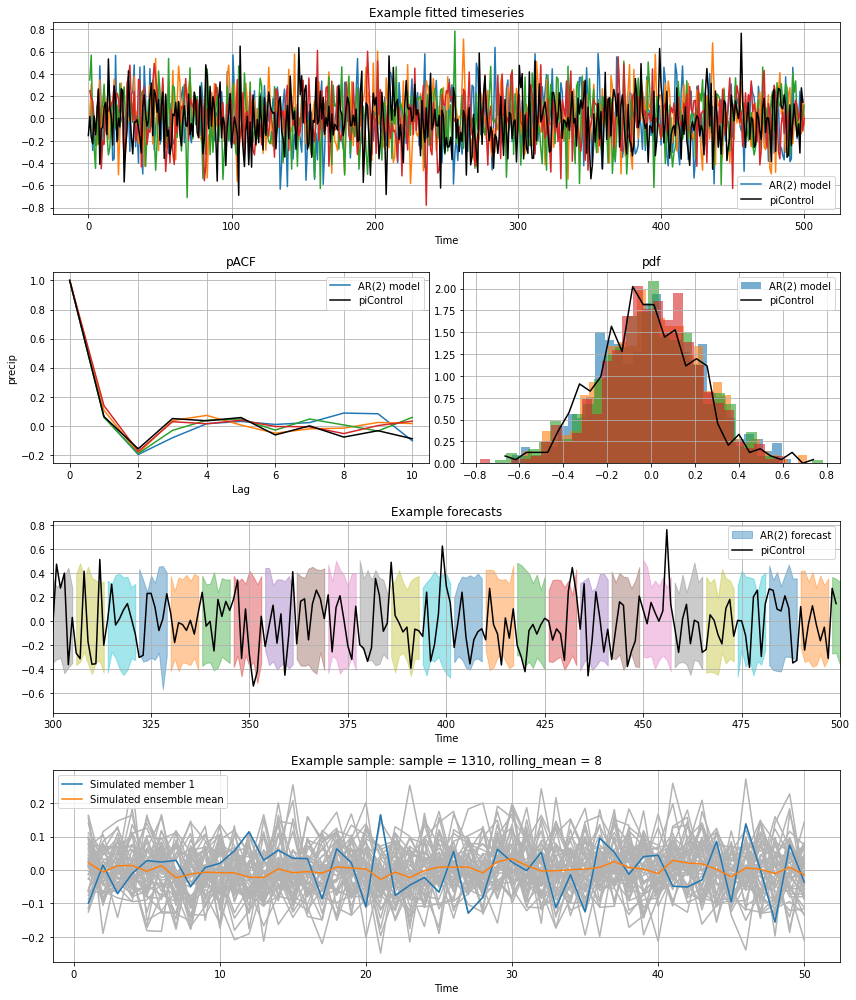

In [120]:
s3_fcst = ar_model.generate_samples_like(
    aus,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    n_members=n_members,
    rolling_means=rolling_means,
    plot_diagnostics=True,
)

s3_obsv = ar_model.generate_samples_like(
    aus,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    rolling_means=rolling_means,
    plot_diagnostics=False,
)

## How to visualise sentivities?

Let's calculate the Type I error rates (i.e. the proportion of samples that reject the null hypothesis when it's actually true) for $\alpha = 0.05$ using various methods for inference

Parameters:
- Sample length (length of `time`)
- Temporal averaging (`rolling_mean`)
- Number of ensemble members (length of `member`)

In [ ]:
samp, p = stats.infer_metric(
    s1_fcst,
    s1_obsv,
    metric="pearson_r",
    method="bootstrap",
    method_kwargs=dict(
        blocks={"time": 5, "member": 1}, n_permutations=1000, transform="Fisher_z"
    ),
)

In [ ]:
samp

In [105]:
(p < 0.05).mean("sample")

<xarray.DataArray (rolling_mean: 4)>
array([0.3301, 0.3448, 0.358 , 0.3792])
Coordinates:
  * rolling_mean  (rolling_mean) int64 1 2 4 8

In [ ]:
def pearsonr_bs(a, b, return_iterations=False, blocksize=5):
    """Return correlation and p-values from block bootstrap procedure"""
    r = verify.rXY(a, b)

    r_bs = verify.rXY(
        *verify.iterative_blocked_bootstrap(
            a,
            b,
            blocks={"time": blocksize, "member": 1},
            n_iterations=10_000,
        )
    )

    if return_iterations:
        return r, r_bs
    else:
        r_trans = verify.Fisher_z(r)
        r_bs_trans = verify.Fisher_z(r_bs)

        left_p = xr.where(r_bs_trans < 0, 1, 0).mean("iteration")
        right_p = xr.where(r_bs_trans > 0, 1, 0).mean("iteration")
        p = xr.where(r_trans >= 0, left_p, right_p) * 2

        return r, p

In [60]:
null = xs.pearson_r(s1_fcst.mean("member"), s1_obsv, dim="time").rename("null")

In [63]:
null

<xarray.DataArray 'null' (rolling_mean: 4, sample: 10000)>
array([[-0.67489827,  0.21875428,  0.64914246, ..., -0.27649503,
         0.0517501 ,  0.54964047],
       [-0.69813713,  0.25215097,  0.68800474, ..., -0.28577209,
         0.01065683,  0.58006105],
       [-0.69597594,  0.31177059,  0.68822836, ..., -0.31285499,
        -0.10541827,  0.61824413],
       [-0.6796412 ,  0.32472721,  0.64478156, ..., -0.35431751,
        -0.4242791 ,  0.69547352]])
Coordinates:
  * sample        (sample) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * rolling_mean  (rolling_mean) int64 1 2 4 8

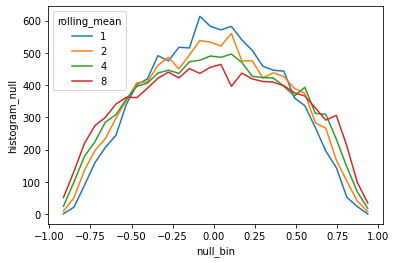

In [64]:
xhist(null, bins=30, dim=["sample"]).plot.line(x="null_bin")

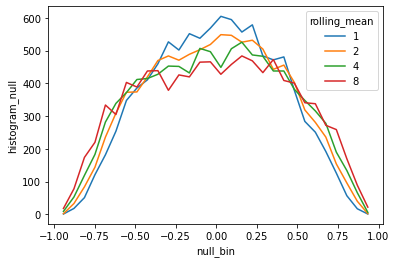

In [50]:
xhist(null, bins=30, dim=["sample"]).plot.line(x="null_bin")

In [38]:


test = xs.pearson_r(s1_fcst.mean("member"), s1_obsv, dim="time")

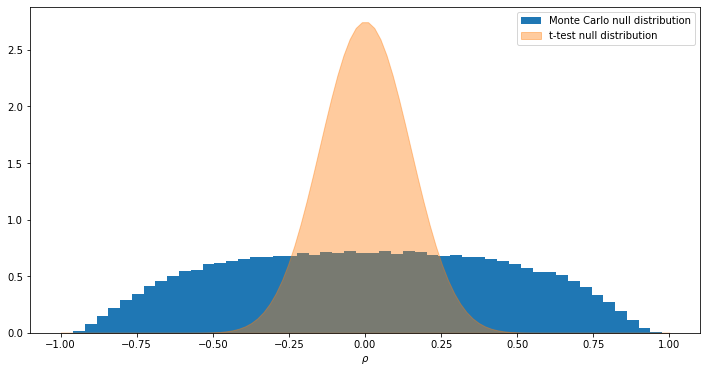

In [39]:
plt.hist(
    test.sel(rolling_mean=8),
    bins=50,
    density=True,
    label="Monte Carlo null distribution",
)

# t-test
r = np.linspace(-1, 1, 100)
plt.fill_between(
    r, utils.student_t(50, r), color="C1", alpha=0.4, label="t-test null distribution"
)

plt.legend()
_ = plt.xlabel(r"$\rho$")

### **s2**: NAO index

In [215]:
def north_atlantic_oscillation(ds):
    """Return the nao index used by Smith et al. (2020)"""
    Azores_box = utils.extract_lon_lat_box(
        ds, box=[332, 340, 36, 40], weighted_average=True
    )
    Iceland_box = utils.extract_lon_lat_box(
        ds, box=[335, 344, 63, 70], weighted_average=True
    )
    nao = Azores_box - Iceland_box
    return nao - nao.mean("time")

In [216]:
ec_nao = north_atlantic_oscillation(ec)["slp"]
s2_coeffs = yule_walker(ec_nao, order=2).compute()

In [217]:
ntimes = len(ec_nao)

ar = np.concatenate(([1], -s2_coeffs.sel(coeff=[1, 2])))
s2_process = ArmaProcess(ar)

s2 = s2_process.generate_sample(nsample=ntimes, scale=s2_coeffs.sel(coeff=0).item())

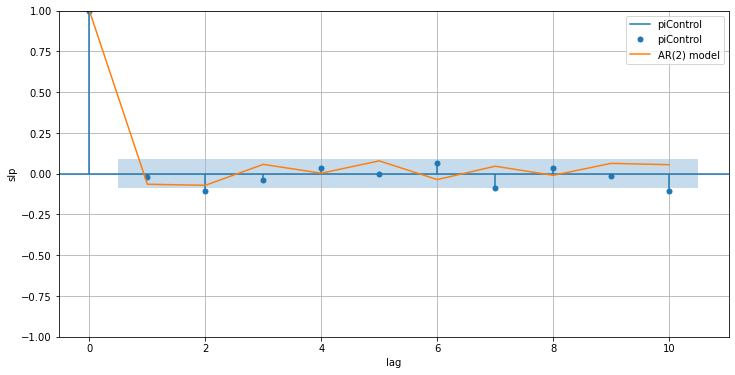

In [218]:
plot_pacf(s2, lags=10, method="ywm", label="piControl")
acf(ec_nao, partial=True).plot(label="AR(2) model")

plt.title("")
plt.grid()
_ = plt.legend()

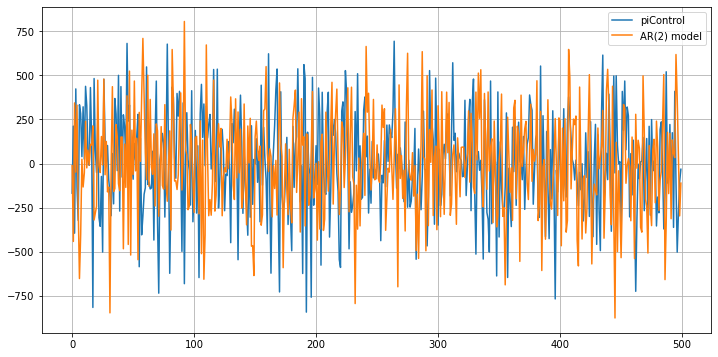

In [219]:
plt.plot(ec_nao, label="piControl")
plt.plot(s2, label="AR(2) model")

plt.grid()
_ = plt.legend()

### Can we build ensemble forecasts with these models?

In [247]:
np.random.standard_normal(50)

array([-1.51745513,  1.92093175, -0.94125319, -1.0254181 , -0.25472485,
        2.19916568, -0.52269948,  0.28218351, -1.76841859, -1.37404369,
       -0.81521254,  2.95730612,  0.36609388,  0.05985637,  2.25451834,
        0.54558068,  0.06496594,  0.01883081,  0.07962581,  1.22004724,
       -1.52973451, -0.5943884 , -0.04607343, -1.04526054, -0.06170846,
        1.7054837 ,  1.31431271,  0.2089277 ,  0.01505166, -1.12590226,
        2.03190828,  0.17505528,  1.35099439, -0.62060778, -1.01546363,
       -0.90103776, -0.79471061,  1.53516759, -0.15305782,  1.57450018,
        0.41350349,  0.21609303, -0.33649965,  0.40340807,  0.32493055,
       -0.40402901, -0.57817948,  0.64798204,  0.62280542,  0.39806471])

In [249]:
init(50)

TypeError: 'numpy.ndarray' object is not callable

In [265]:
def init(size):
    return np.zeros(size)

In [266]:
ntimes = 50
nensemble = 10

ar = np.concatenate(([1], -s1_coeffs.sel(coeff=[1, 2])))
s1_process = ArmaProcess(ar)

s1_obsv = s1_process.generate_sample(
    nsample=ntimes, scale=s1_coeffs.sel(coeff=0).item(), distrvs=init
)

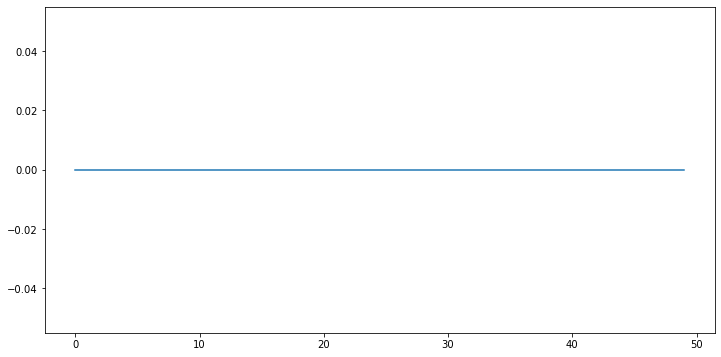

In [267]:
plt.plot(s1_obsv)

In [78]:
from statsmodels.tsa.ar_model import AutoReg

In [149]:
test = can["sst"].sel(lat=60, lon=180, method="nearest").compute().values

In [203]:
f = AutoReg(test, lags=2, trend="n").fit()

In [204]:
f.params

array([0.54150323, 0.01317337])

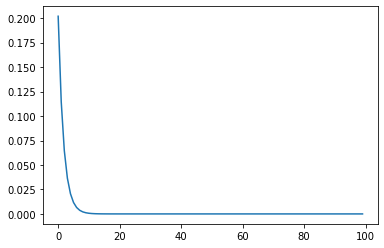

In [205]:
plt.plot(f.forecast(100))

In [206]:
from statsmodels.regression.linear_model import yule_walker

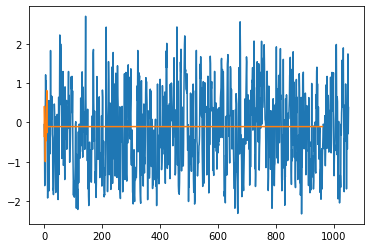

In [181]:
plt.plot(test)

plt.plot(f.predict(start=1040, end=2000, dynamic=1050))

In [ ]:
def AutoReg(ds, dim="time", partial=False, nlags=10):
    """Vectorized Autocorrelation Function for xarray objects"""
    import statsmodels.api as sm

    def _acf(data, nlags, partial):
        if partial:
            return sm.tsa.pacf(data, nlags=nlags)
        else:
            return sm.tsa.acf(data, nlags=nlags)

    return xr.apply_ufunc(
        _acf,
        ds,
        kwargs=dict(nlags=nlags, partial=partial),
        input_core_dims=[[dim]],
        output_core_dims=[["lag"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={"lag": nlags + 1}),
    ).assign_coords({"lag": range(nlags + 1)})

In [73]:
def init(size):
    
    return arma_process.generate_sample(nsample=size[0])

In [74]:
nsamples = 100
ntimes = 50

ar = np.array([1, -0.8])

arma_process = ArmaProcess(ar)
s = arma_process.generate_sample(nsample=(nsamples, 2), distrvs=init, axis=0)

In [77]:
s.shape

(100,)

In [68]:
s.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [54]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [55]:
import statsmodels.tsa.ar_model

In [ ]:
AutoReg()

In [52]:
np.std(s)

1.2884386827350243

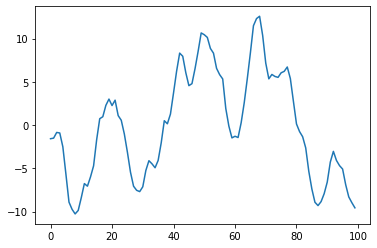

In [75]:
plt.plot(s)

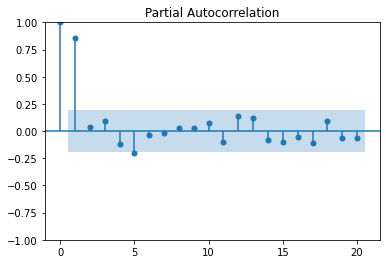

In [45]:
_ = plot_pacf(s, method="ywm")